In [1]:
%%capture
%pip install numpy pyfluids scipy matplotlib tqdm pandas seaborn

import numpy as np

from pyfluids import Fluid, FluidsList, Input
from pyfluids.enums import Phases

from scipy.optimize import minimize_scalar, shgo, dual_annealing, differential_evolution

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import multiprocessing
from tqdm import tqdm
import pandas as pd

In [2]:
GRAVITY = 9.81

In [3]:
c_ohh_two = Fluid(FluidsList.CarbonDioxide)

## Constants

In [4]:
dioxide_temp = 20
dioxide_temp

20

In [5]:
dioxide_pressure = 6e6
dioxide_pressure

6000000.0

In [6]:
well_dists = np.array([70, 112])
well_dists

array([ 70, 112])

In [7]:
sequestration_rate = 3.24 # kg / s
sequestration_rate

3.24

In [8]:
well_depth = 3.2e3 # m

In [9]:
cold_well_temp = 2 # C

In [10]:
tube_diam = 2.375 * 0.0254
tube_thickness = 0.154 * 0.0254

casing_diam = 5.563 * 0.0254
casing_thickness = 0.258 * 0.0254

soil_effective_thickness = 2

tube_radii = [tube_diam / 2 - tube_thickness, tube_diam / 2, casing_diam / 2 - casing_thickness, casing_diam / 2, casing_diam / 2 + soil_effective_thickness]

conservative_roughness = 0.229e-3 / (2 * tube_radii[0])

carbon_steel_conductivity = 45 # W/mK
copper_conductivity = 401 # W/mK
concrete_conductivity = 2.25 # W/mK
soil_conductivity = 1 # W/mK

down_tube_conductivities = [copper_conductivity, concrete_conductivity, carbon_steel_conductivity, soil_conductivity]
up_tube_conductivities = [carbon_steel_conductivity, concrete_conductivity, carbon_steel_conductivity, soil_conductivity]

# Stuff To Check
* Make condenser outlet match the CO_2 Supply

## Vertical Pipe Slices

In [11]:
def radial_thermal_conduction(inner_radius, outer_radius, length, conductivity):
    return np.log(outer_radius / inner_radius) / (2 * np.pi * conductivity * length)

radial_thermal_conduction(0.1, 0.2, 1, 0.1)

1.103178000763258

In [12]:
def thermal_convection(mass_flow, fluid: Fluid, radius, length, heat_into_fluid):
    volumetric_flow = mass_flow / fluid.density
    velocity = volumetric_flow / (np.pi * radius ** 2)
    
    reynolds = 2 * radius * velocity / fluid.kinematic_viscosity

    if reynolds < 2300:
        nusselt = 3.66
    else:
        prandtl_exponent = 0.4 if heat_into_fluid else 0.3
        nusselt = 0.023 * reynolds ** 0.8 * fluid.prandtl ** prandtl_exponent
    
    h = nusselt * fluid.conductivity / (2 * radius)

    return 1 / (2 * np.pi * radius * length * h)



thermal_convection(1, c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(-20)
), 0.1, 1, True)

0.03185715590417421

In [13]:
def friction_head_loss(mass_flow, fluid: Fluid, radius, length, relative_roughness=0.001):
    volumetric_flow = mass_flow / fluid.density
    velocity = volumetric_flow / (np.pi * radius ** 2)
    
    reynolds = 2 * radius * velocity / fluid.kinematic_viscosity

    if reynolds < 2300:
        friction_factor = 64 / reynolds
    else:
        # From https://github.com/MarkusPic/moody_chart/blob/master/moody_chart/moody_chart.py
        def _func(lambda_):
            return abs(1 / np.sqrt(lambda_) + 2 * np.log10(2.51 / (reynolds * np.sqrt(lambda_)) + 1 / 3.71 * relative_roughness))

        lambda_bounds = (0.01, 0.1)
        friction_factor = minimize_scalar(_func, method='bounded', bounds=lambda_bounds).x

    

    return friction_factor * length / (radius * 2) * velocity ** 2 / 2 / GRAVITY

friction_head_loss(1, c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(-20)
), 0.1, 1)

1.174182632286475

In [14]:
def soil_temp(depth):
    return 20 + 62.5 / 1e3 * depth

soil_temp(3.2e3)

220.0

## Flow Through Formation

### Heat Transfer

In [15]:
A = 2
r = A ** 0.5 / np.pi
P = r * 2 * np.pi

def in_formation_heat_transfer(mass_flow, fluid: Fluid, well_to_well):
    well_temp = 220

    nusselt = 450

    h = nusselt * soil_conductivity / (2 * r)

    outlet_to_inlet_ratio = np.exp(-P * well_to_well * h / (mass_flow * fluid.specific_heat))

    return well_temp - (well_temp - fluid.temperature) * outlet_to_inlet_ratio

in_formation_heat_transfer(1, c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(100)
), 140)

220.0

### Pressure Drop

In [16]:
def in_formation_pressure_drop(mass_flow, fluid: Fluid, well_to_well):
    volumetric_flow = mass_flow / fluid.density

    perm = 1e-12
    
    return volumetric_flow * fluid.dynamic_viscosity * well_to_well / A / perm

in_formation_pressure_drop(1, c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(200)
), 140)

1425710213.3965037

## Condensor

In [17]:
def UA_from_cond_ops(inlet_fluid: Fluid, outlet_fluid: Fluid, cold_well_temp, mass_flow_rate):
    if inlet_fluid.temperature < outlet_fluid.temperature:
        return 0
    
    heat_transfer = mass_flow_rate * (inlet_fluid.enthalpy - outlet_fluid.enthalpy)

    log_mean_temp = inlet_fluid.temperature  - outlet_fluid.temperature
    log_mean_temp /= np.log((inlet_fluid.temperature - cold_well_temp) / (outlet_fluid.temperature - cold_well_temp))

    return heat_transfer / log_mean_temp

UA_from_cond_ops(c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(200)
), c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(20)
), 2, 1)

2219.6061458550016

## System Solving

## Overall State Variables when Optimizing

* Mass flow rate (possible two up values)
* Turbine Outlet Pressure
* Compressor Outlet Pressure
* Turbine & Compressor Efficiency

Fluid State Vector into each slice

constant mass flow rate down

* Enthalpy
  + Changes by Heat Transfer
    - Constant Soil Temp given the linear
    - slice of 2m of soil
    - cond through 3 pipe layer stackup
    - convective analysis with const Ts
  + Increases by frictional losses
  

* Pressure
  + Increase by rho g delta Z
  + Decrease by frictional losses

In [18]:
def SolveSlice(mass_flow, start_depth, end_depth, inlet_fluid: Fluid):
    thermal_network = []

    delta_h = -(end_depth - start_depth)
    length = abs(delta_h)

    avg_depth = (start_depth + end_depth) / 2

    inside_BC = inlet_fluid.temperature
    outside_BC = soil_temp(avg_depth)
    
    thermal_network.append(
      thermal_convection(mass_flow, inlet_fluid, tube_radii[0], length, inside_BC < outside_BC)
    )

    for ind, cond in enumerate(down_tube_conductivities if delta_h < 0 else up_tube_conductivities):
      inner = tube_radii[ind]
      outer = tube_radii[ind + 1]

      thermal_network.append(
        radial_thermal_conduction(inner, outer, length, cond)
      )


    overall_resistance = sum(thermal_network)

    heat_transfer_in = (outside_BC - inside_BC) / overall_resistance

    frictional_head_loss = friction_head_loss(mass_flow, inlet_fluid, tube_radii[0], length)

    outlet_fluid = c_ohh_two.with_state(
      # Input.internal_energy(inlet_fluid.internal_energy + heat_transfer_in / mass_flow + frictional_head_loss * GRAVITY),
      Input.temperature(inlet_fluid.temperature + heat_transfer_in / mass_flow / inlet_fluid.specific_heat),
      Input.pressure(inlet_fluid.pressure + inlet_fluid.density * GRAVITY * (-delta_h - frictional_head_loss))
    )
    
    # assert outlet_fluid.phase == Phases.Liquid

    return outlet_fluid

In [19]:
class SystemSolution:
  def __init__(self, flow_rates, turbine_outlet_pressure, compressor_outlet_pressure, turbine_efficiency, compressor_efficiency, supply_fluid: Fluid, VERTICAL_SLICES = 200):

    self.downward_flow_rate = sum(flow_rates) + sequestration_rate

    self.post_comp_isen =  c_ohh_two.with_state(Input.pressure(compressor_outlet_pressure),
                                              Input.entropy(supply_fluid.entropy))
    # assert self.post_comp_isen.phase == Phases.Liquid, f"CO2 is now {self.post_comp_isen.phase} after the compressor"
    

    self.post_compressor =  c_ohh_two.with_state(Input.pressure(compressor_outlet_pressure),
                                              Input.enthalpy(supply_fluid.enthalpy + (self.post_comp_isen.enthalpy - supply_fluid.enthalpy) / compressor_efficiency))
    # assert self.post_compressor.phase == Phases.Liquid
    
    # self.slice_log = []
    
    input = self.post_compressor
    for slice in range(VERTICAL_SLICES):
      output = SolveSlice(self.downward_flow_rate,
                          slice / VERTICAL_SLICES * well_depth,
                          (slice + 1) / VERTICAL_SLICES * well_depth,
                          input)

      # self.slice_log.append(output)
      input = output
    
    self.pre_formation = output

    self.up_states = [c_ohh_two.with_state(Input.pressure(self.pre_formation.pressure - in_formation_pressure_drop(flow_rate, self.pre_formation, well_dist)),
                                          Input.temperature(in_formation_heat_transfer(flow_rate, self.pre_formation, well_dist))) for flow_rate, well_dist in zip(flow_rates, well_dists)]
    # for up_state in self.up_states:
    #   assert up_state.phase == Phases.Liquid

    # upward_logs = [[], []]

    self.pre_turbines = []

    for usi, up_state in enumerate(self.up_states):
      input = up_state
      for slice in range(VERTICAL_SLICES):
        output = SolveSlice(flow_rates[usi],
                              well_depth - slice / VERTICAL_SLICES * well_depth,
                              well_depth - (slice + 1) / VERTICAL_SLICES * well_depth,
                              input)

        # upward_logs[usi].append(output)
        input = output

      self.pre_turbines.append(output)

    self.post_turb_isens = [ c_ohh_two.with_state(Input.pressure(turbine_outlet_pressure),
                                              Input.entropy(pre_turbine.entropy)) for pre_turbine in self.pre_turbines]
    
    # for post_turb_isen in self.post_turb_isens:
    #   assert post_turb_isen.phase == Phases.Liquid

    self.post_turbines = [ c_ohh_two.with_state(Input.pressure(turbine_outlet_pressure),
                                            Input.enthalpy(pre_turbine.enthalpy - turbine_efficiency * (pre_turbine.enthalpy - post_turb_isen.enthalpy))) for pre_turbine, post_turb_isen in zip(self.pre_turbines, self.post_turb_isens)]
    
    # for post_turbine in self.post_turbines:
    #   assert post_turbine.phase == Phases.Liquid
    
    self.post_tee =  c_ohh_two.with_state(Input.pressure(turbine_outlet_pressure), Input.enthalpy(sum([post_turbine.enthalpy * flow_rate for post_turbine, flow_rate in zip(self.post_turbines, flow_rates)]) / sum(flow_rates)))
    # assert self.post_tee.phase == Phases.Liquid
  
    self.condensorUA = UA_from_cond_ops(self.post_tee, supply_fluid, cold_well_temp, sum(flow_rates))

    self.turbine_production = sum([(pre_turbine.enthalpy - post_turbine.enthalpy) * flow_rate for pre_turbine, post_turbine, flow_rate in zip(self.pre_turbines, self.post_turbines, flow_rates)])
    self.compressor_consumption = (self.post_comp_isen.enthalpy - supply_fluid.enthalpy) * self.downward_flow_rate

  def __repr__(self):
    return f"Condensor UA:           {self.condensorUA:.5g} W/K\nTurbine Production:     {self.turbine_production:.5g} W\nCompressor Consumption: {self.compressor_consumption:.5g} W\nNet Power:              {self.turbine_production - self.compressor_consumption:.5g} W"

sol = SystemSolution( flow_rates=[2.852, 1.852],
                      turbine_outlet_pressure=dioxide_pressure,
                      compressor_outlet_pressure=100.000e+06,
                      turbine_efficiency=0.85,
                      compressor_efficiency=0.85,
                      supply_fluid=c_ohh_two.with_state(
                                          Input.pressure(dioxide_pressure),
                                          Input.temperature(dioxide_temp)
                                        ))
sol

Condensor UA:           17664 W/K
Turbine Production:     4.0536e+05 W
Compressor Consumption: 8.1002e+05 W
Net Power:              -4.0466e+05 W

In [20]:
def slice_print(sol):
    presses = [s.pressure for s in sol.slice_log]
    denses = [s.density for s in sol.slice_log]
    temps = [s.temperature for s in sol.slice_log]
    enthalps = [s.enthalpy for s in sol.slice_log]
    internal_energies = [s.internal_energy for s in sol.slice_log]
    entropies = [s.entropy for s in sol.slice_log]

    depths = [ind / len(sol.slice_log) * well_depth for ind, _ in enumerate(sol.slice_log)]

    # Create a figure with two subplots
    fig, axes = plt.subplots(6, figsize=(8, 12))

    axes[0].plot(depths, presses)
    axes[0].set_title('Pressures')
    axes[0].set_xlabel('Depth')
    axes[0].set_ylabel('Pressure Pa')

    axes[1].plot(depths, denses)
    axes[1].set_title('Density')
    axes[1].set_xlabel('Depth')
    axes[1].set_ylabel('Density Kg/m^3')

    axes[2].plot(depths, temps)
    axes[2].set_title('Temperature')
    axes[2].set_xlabel('Depth')
    axes[2].set_ylabel('Temps C')

    axes[3].plot(depths, enthalps)
    axes[3].set_title('Enthalpy')
    axes[3].set_xlabel('Depth')
    axes[3].set_ylabel('Enthalpy KJ/Kg')

    axes[4].plot(depths, internal_energies)
    axes[4].set_title('Internal Energy')
    axes[4].set_xlabel('Depth')
    axes[4].set_ylabel('Internal Energy KJ/Kg')

    axes[5].plot(depths, entropies)
    axes[5].set_title('Entropy')
    axes[5].set_xlabel('Depth')
    axes[5].set_ylabel('Entropy KJ/KgK')

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


In [21]:
# Define the objective function
def objective_function(args):
  lfr, rfr, compressor_outlet_pressure = args
  try:
    sol = SystemSolution(flow_rates=[lfr, rfr],
              turbine_outlet_pressure=dioxide_pressure,
              compressor_outlet_pressure=compressor_outlet_pressure,
              turbine_efficiency=0.85,
              compressor_efficiency=0.85,
              supply_fluid=c_ohh_two.with_state(Input.pressure(dioxide_pressure),
                                                Input.temperature(dioxide_temp)))
    return sol.turbine_production - sol.compressor_consumption
  except Exception as e:
    return 0

objective_function((1.5, 1.5, 7.000e+06))

72587.09017033807

In [22]:
bounds = [(1, 4), (1, 4), (dioxide_pressure+ 1e6, 400e6)]

def nobjective_function(args):
  return -objective_function(args)

shgo_sol = shgo(nobjective_function, bounds)

if shgo_sol.success:
  print(f"Left Flow Rate:  {shgo_sol.x[0]:.5g} (kg/s)\nRight Flow Rate: {shgo_sol.x[1]:.5g} (kg/s)\nCompressor Outlet Pressure: {shgo_sol.x[2]:.5g} Pa\nNet Power Production: {objective_function(shgo_sol.x):.5g} W")

Left Flow Rate:  1.9412 (kg/s)
Right Flow Rate: 1.4893 (kg/s)
Compressor Outlet Pressure: 7e+06 Pa
Net Power Production: 79249 W


In [23]:
optimal = SystemSolution(flow_rates=[shgo_sol.x[0], shgo_sol.x[1]],
                          turbine_outlet_pressure=dioxide_pressure,
                          compressor_outlet_pressure=shgo_sol.x[2],
                          turbine_efficiency=0.85,
                          compressor_efficiency=0.85,
                          supply_fluid=c_ohh_two.with_state(Input.pressure(dioxide_pressure),
                                                            Input.temperature(dioxide_temp)))
optimal

Condensor UA:           23810 W/K
Turbine Production:     87731 W
Compressor Consumption: 8481.4 W
Net Power:              79249 W

In [24]:
for p, m_dot in zip(optimal.pre_turbines, shgo_sol.x[0:2]):
  press, dense, temp = p.pressure, p.density, p.temperature
  print(f"Vol Flow: {m_dot / dense:.5g} m^3/s, Pressure: {press:.5g} Pa, Density: {dense:.5g} kg/m^3, Temperature: {temp:.5g} C")

Vol Flow: 0.0090747 m^3/s, Pressure: 1.1462e+07 Pa, Density: 213.91 kg/m^3, Temperature: 108.16 C
Vol Flow: 0.0066201 m^3/s, Pressure: 1.1053e+07 Pa, Density: 224.97 kg/m^3, Temperature: 94.797 C


Stored State Points:
state        T (K)       p (Pa)    d (kg/m3)     h (J/kg)   s (J/kg/K)
    0       20.000  6000000.000      782.648   254278.655     1181.120
    1       21.699  7000000.252      789.449   255774.501     1181.881
    2       53.706  27009153.549      833.654   299501.556     1243.507
    3      220.000  20612303.293      248.408   623253.508     2094.246
    4      108.164  11462474.902      213.913   505299.652     1913.988
    5       56.342  6000000.000      128.367   478167.899     1928.591
    6       51.999  6000000.000      132.918   471667.245     1908.730



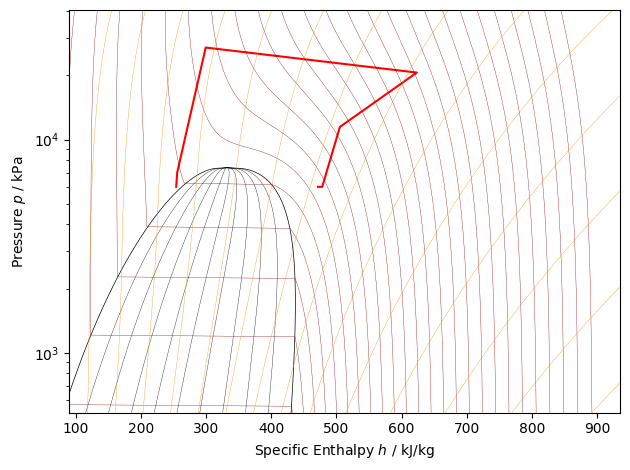

In [25]:
def cycle_ph(*state_list):
    import CoolProp
    from CoolProp.Plots import PropertyPlot
    from CoolProp.Plots.SimpleCycles import StateContainer
    from CoolProp.Plots.Common import BasePlot

    cycle_states = StateContainer()

    for ind, state in enumerate(state_list):
        cycle_states[ind,'H'] = state.enthalpy
        cycle_states[ind,'S'] = state.entropy
        cycle_states[ind,'D'] = state.density
        cycle_states[ind,CoolProp.iP] = state.pressure
        cycle_states[ind,CoolProp.iT] = state.temperature


    print(cycle_states)

    pp = PropertyPlot('CO2', 'PH')
    
    old_limits = pp.get_axis_limits()
    pp.set_axis_limits([
        old_limits[0],
        max(old_limits[1], 1.5 * max([state.enthalpy for state in state_list]) / 1e3),
        old_limits[2],
        max(old_limits[3], 1.5 * max([state.pressure for state in state_list]) / 1e3),
    ])
    
    pp.draw_process(cycle_states)

    pp.calc_isolines(CoolProp.iQ, num=11)
    pp.calc_isolines(CoolProp.iT, num=25)
    pp.calc_isolines(CoolProp.iSmass, num=15)
    
    pp.show()

import warnings
warnings.filterwarnings("ignore")
cycle_ph( c_ohh_two.with_state(Input.pressure(dioxide_pressure), Input.temperature(dioxide_temp)),
          optimal.post_compressor,
          optimal.pre_formation,
          optimal.up_states[0],
          optimal.pre_turbines[0],
          optimal.post_turbines[0],
          optimal.post_tee)

Using 80 processes


100%|██████████| 1000/1000 [01:14<00:00, 13.44it/s] 


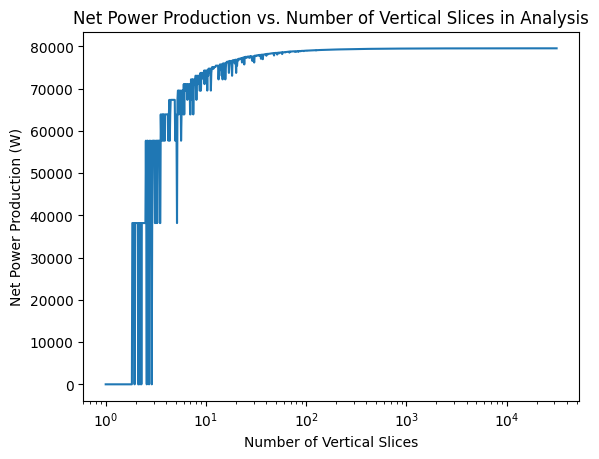

In [26]:
slices = np.logspace(0, 4.5, 1000)

def slice_check(slice_count):
  left_flow, right_flow, compressor_outlet_pressure = shgo_sol.x
  
  try:
    sol = SystemSolution(flow_rates=[left_flow, right_flow],
              turbine_outlet_pressure=dioxide_pressure,
              compressor_outlet_pressure=compressor_outlet_pressure,
              turbine_efficiency=0.85,
              compressor_efficiency=0.85,
              supply_fluid=c_ohh_two.with_state(Input.pressure(dioxide_pressure),
                                                Input.temperature(dioxide_temp)),
              VERTICAL_SLICES=int(slice_count))
    return sol.turbine_production - sol.compressor_consumption
  except Exception as e:
    return 0

# Define the number of processes to use
num_processes = multiprocessing.cpu_count()
print(f"Using {num_processes} processes")

# Create a multiprocessing pool
pool = multiprocessing.Pool(processes=num_processes)

# Apply the objective function to each parameter combination using multiprocessing
results = []
with tqdm(total=len(slices)) as pbar:
  for result in pool.imap_unordered(slice_check, slices):
    results.append(result)
    pbar.update(1)

# Close the multiprocessing pool
pool.close()

plt.plot(slices, results)
plt.title("Net Power Production vs. Number of Vertical Slices in Analysis")
plt.xlabel("Number of Vertical Slices")
plt.ylabel("Net Power Production (W)")
plt.xscale('log')
plt.show()

In [27]:
sol = SystemSolution(flow_rates=[2.0, 2.0],
              turbine_outlet_pressure=dioxide_pressure,
              compressor_outlet_pressure=10e6,
              turbine_efficiency=0.85,
              compressor_efficiency=0.85,
              supply_fluid=c_ohh_two.with_state(Input.pressure(dioxide_pressure),
                                                Input.temperature(dioxide_temp)))

In [28]:
def topo_map(left_flows, right_flows, presses, drop_zeros=False, drop_negatives=False):
    # Create` a list of parameter combinations
    param_combinations = [(lfr, rfr, compressor_outlet_pressure)
                for lfr in left_flows
                for rfr in right_flows
                for compressor_outlet_pressure in presses]

    # Define the number of processes to use
    num_processes = multiprocessing.cpu_count() # * 3//4

    print(f"Using {num_processes} processes")

    # objective_function(param_combinations[len(param_combinations) // 2])

    # Create a multiprocessing pool
    pool = multiprocessing.Pool(processes=num_processes)

    # Apply the objective function to each parameter combination using multiprocessing
    results = []
    with tqdm(total=len(param_combinations)) as pbar:
      for result in pool.imap_unordered(objective_function, param_combinations):
        results.append(result)
        pbar.update(1)

    # Close the multiprocessing pool
    pool.close()

    # Create a DataFrame from the results and param_combinations
    first_column = [params[0] for params in param_combinations]
    second_column = [params[1] for params in param_combinations]
    third_column = [params[2] for params in param_combinations]

    df = pd.DataFrame({'Left Flow Rate': first_column, 'Right Flow Rate': second_column, 'Compressor Outlet Pressure': third_column, 'Net Power': results})
    df
    
    if drop_zeros and drop_negatives:
      df = df[df['Net Power'] > 0]
    elif drop_negatives:
      df = df[df['Net Power'] >= 0]
    elif drop_zeros:
      df = df[df['Net Power'] != 0]
      
    
    # Create the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    ind = 0
    for a in df.columns[:-1]:
      for b in df.columns[:-1]:
        if a != b and a < b:
          ax = axes[ind]


          # Plot the data in each subplot
          # Group the data by left and right flow rates and find the maximum net power
          max_net_power = df.groupby([a, b])['Net Power'].max()

          # Convert the grouped data into a DataFrame
          max_net_power_df = max_net_power.reset_index()
          im = ax.scatter(max_net_power_df[a], max_net_power_df[b], c=max_net_power_df['Net Power'], cmap='viridis')

          ax.set_xlabel(a)
          ax.set_ylabel(b)

          # divider = make_axes_locatable(axes[ind])
          # cax = divider.append_axes('right', size='5%', pad=0.0)
          fig.colorbar(im, ax=ax, orientation='vertical')
          
          ind += 1

    plt.show()

Using 80 processes


100%|██████████| 18000/18000 [00:43<00:00, 411.41it/s]


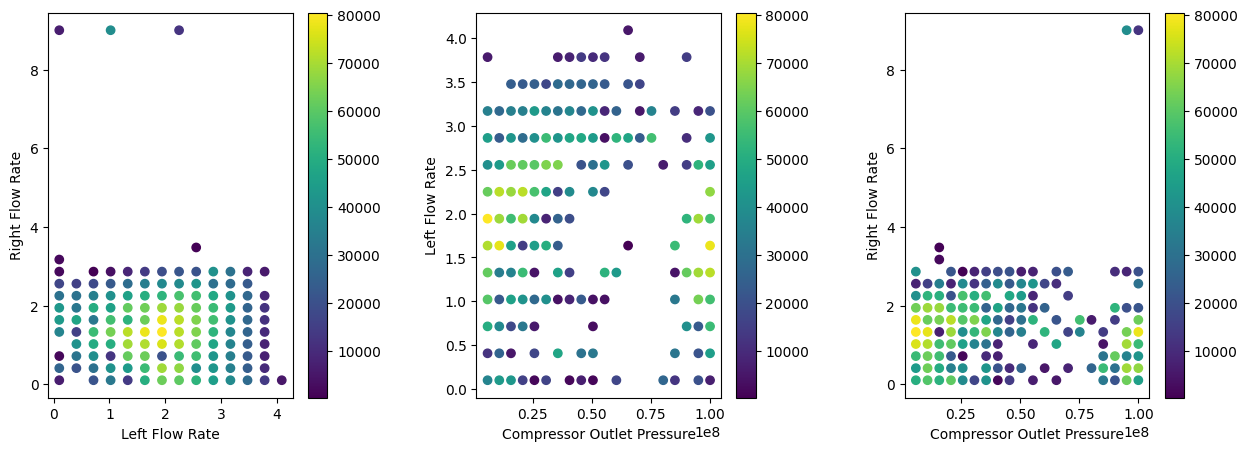

In [29]:
left_range = np.linspace(0.1, 9, 30)
right_range = np.linspace(0.1, 9, 30)
press_range = np.linspace(dioxide_pressure, 1e9, 20) 

topo_map(left_range, right_range, press_range, drop_zeros=True, drop_negatives=True)

Using 80 processes


100%|██████████| 27000/27000 [01:28<00:00, 304.49it/s]


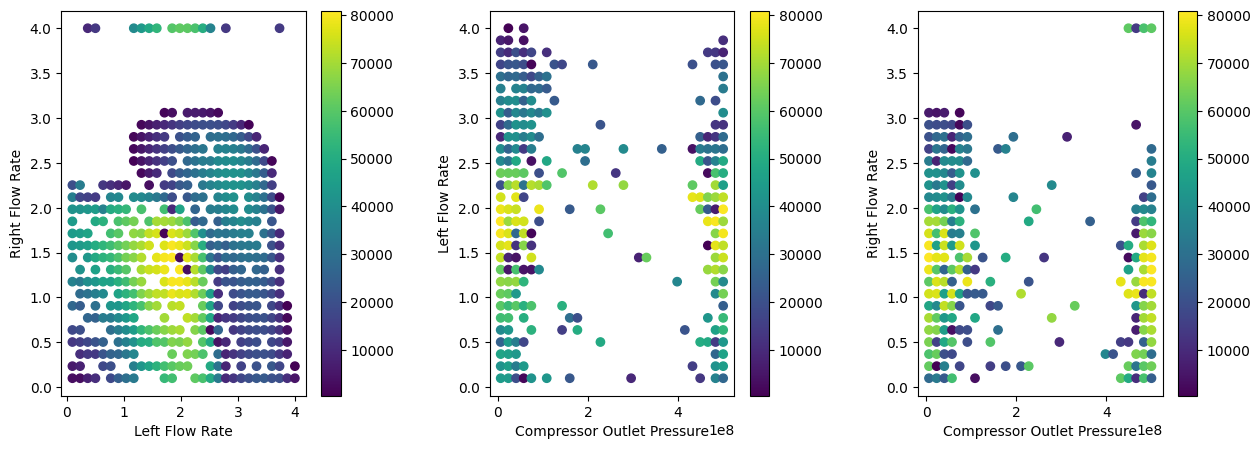

In [30]:
left_range = np.linspace(0.1, 4.0, 30)
right_range = np.linspace(0.1, 4.0, 30)
press_range = np.linspace(dioxide_pressure, 500e6, 30) 

topo_map(left_range, right_range, press_range, drop_zeros=True, drop_negatives=True)

Using 80 processes


100%|██████████| 90000/90000 [05:05<00:00, 294.53it/s]


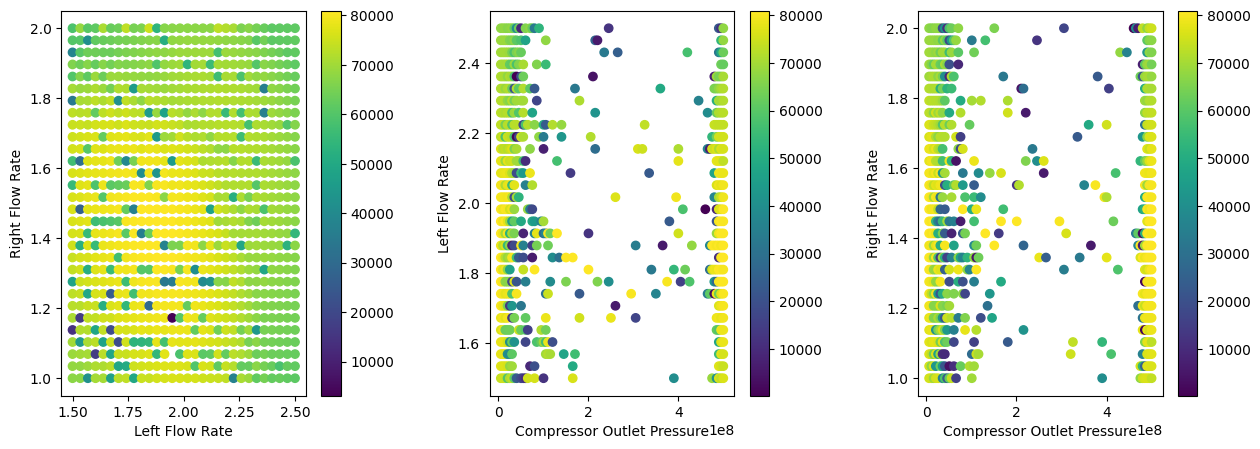

In [31]:
left_range = np.linspace(1.5, 2.5, 30)
right_range = np.linspace(1.0, 2.0, 30)
press_range = np.linspace(dioxide_pressure, 500e6, 30) 

topo_map(left_range, right_range, press_range, drop_zeros=True, drop_negatives=True)